# Predictive Model

The metrics that will be used to evaluate this stage are:

- **Diversity** of tasks (use of classification and regression) and of algorithms, this is, tested more than 4 with significantly different language bias OR with a significant number of variants.

- **Parameter Tuning**, with a systematic approach.

- **Understanding Algorithm Behavior**, solid (even if not deep) understanding of the behavior of most algorithms used OR <3 algorithms, also understanding the effect of parameters.

- Training and testing on properly separated data, with multiple splits.

- **Performance Estimation**, additional factors correctly taken into account (e.g. time), focus on performance measures aligned with DM goals and data characteristics, advanced performance measures (e.g. AUC), adequate baseline, correct analysis of values ​​for comparison, including tests of statistical significance, correct estimate of overfitting.

- **Model Improvement**, development guided by performance improvement goals, even if pedagogical goals have not been ignored.

- **Feature Importance**, correctly interpreted, related to the application domain.

- Analysis of "white box" models, correctly interpreted, related to the application domain

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import optuna
import time
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold

SEED = 42
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)
BEST_MODELS = {}


teams = pd.read_csv("data_prepared/teams.csv")
label_encoder = LabelEncoder()
numerical_features = teams.select_dtypes(include=['float', 'int']).columns
numerical_features = numerical_features.drop('year')
scaler = StandardScaler()
teams[numerical_features] = scaler.fit_transform(teams[numerical_features])
teams['playoff'] = teams['playoff'].map({'Y': 1, 'N': 0})
teams['confID'] = teams['confID'].map({'EA': 0, 'WE': 1})


def encode_categorical_columns(df):
    for col in df.select_dtypes(include=['object']).columns:
        if col == 'playoff' or col == 'confID': continue
        else: df[col] = label_encoder.fit_transform(df[col])
    return df


encode_categorical_columns(teams)
teams = teams.fillna(0)

In [31]:
# Função para normalizar previsões
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif


def normalize_predictions(predictions):
    return (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))


# Função para calcular o erro
def get_error(pred_proba, label_playoff):
    errors = []
    for pred, label in zip(pred_proba, label_playoff):
        errors.append(abs(pred - label))
    return sum(errors)


# Função para dividir os dados em treino e teste
def get_train_and_test_data(data, year):
    train = data[((data['year'] < year) | (data['year'] > year)) & (data['year'] != 11)].drop("year", axis=1)
    test = data[data['year'] == year].drop("year", axis=1)
    X_train, Y_train = train.drop("playoff", axis=1), train["playoff"]
    X_test, Y_test = test.drop("playoff", axis=1), test["playoff"]
    smote = SMOTE(random_state=SEED)
    X_train, Y_train = smote.fit_resample(X_train, Y_train)
    return X_train, Y_train, X_test, Y_test


# Select best features using RFECV
def select_best_features(X_train, Y_train, feature_list, n_features):
    selector = SelectKBest(f_classif, k=n_features)
    selector.fit(X_train[feature_list], Y_train)
    selected_features = [feature_list[i] for i in range(len(feature_list)) if selector.get_support()[i]]    
    print(selected_features)
    return selected_features + ['tmID']


# Função para rodar o modelo
def run_model(model, data, year, number, only_df=False, n_features=20):
    # feature_list = [
    #     'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_asts',
    #     'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm',
    #     'd_3pa', 'd_oreb', 'd_dreb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'won',
    #     'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'min', 'wonPost', 'lostPost',
    #     'wonPointsPost', 'lostPointsPost', 'awards_players', 'awards_coaches', 'offensive_efficiency',
    #     'defensive_efficiency', 'play_percent', 'factors4', 'possession', 'opponent_possession',
    #     'avg_pie', 'avg_per'
    # ]
    
    feature_list = [
        'per_o_fgm','per_o_ftm','per_o_3pm', 'o_oreb', 'o_dreb', 'o_asts',
        'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'per_d_fgm','per_d_ftm', 'per_d_3pm', 'd_oreb', 'd_dreb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'won',
        'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'min', 'wonPost', 'lostPost',
        'wonPointsPost', 'lostPointsPost', 'awards_players', 'awards_coaches', 'offensive_efficiency',
        'defensive_efficiency', 'play_percent', 'factors4', 'possession', 'opponent_possession',
        'avg_pie', 'avg_per'
    ]
        
    X_train, Y_train, X_test, Y_test = get_train_and_test_data(data, year)
    selected_features = select_best_features(X_train, Y_train, feature_list, n_features)
    X_train, X_test = X_train[selected_features], X_test[selected_features]
    
    start_timer = time.time()
    model.fit(X_train, Y_train)
    # model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    # model.fit(X_train, Y_train)

    # Fazer as previsões
    if isinstance(model, (LinearRegression, RandomForestRegressor)):
        y_pred = model.predict(X_test)
        y_pred_proba = normalize_predictions(y_pred)
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    error = get_error(y_pred_proba, Y_test)

    # Preparar as previsões binárias
    number = min(number, len(y_pred_proba))

    # Preparar as previsões binárias
    y_pred = np.zeros_like(y_pred_proba)
    top_indices = np.argsort(y_pred_proba)[-number:]
    y_pred[top_indices] = 1
    stop_timer = time.time()

    # Construir o DataFrame de previsões
    prediction_df = pd.DataFrame()
    prediction_df['tmID'] = label_encoder.inverse_transform(X_test['tmID'])
    prediction_df['Playoff'] = y_pred_proba
    if only_df: return prediction_df
    prediction_df['Playoff_Binary'] = y_pred
    prediction_df['Playoff_Labeled'] = Y_test.values
    
    # Estatísticas
    time_elapsed = stop_timer - start_timer
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    accuracy = accuracy_score(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)

    return prediction_df, {
        "time": time_elapsed,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "auc": auc,
        "error": error
    }


In [32]:
results_accuracy = {}
results_precision = {}
results_error = {}

def run_model_by_conferences(model, year):
    
    if year == 11:
        east_pred_df = run_model(model, teams[teams['confID'] == 0], year, 4, True)       
        weast_pred_df = run_model(model, teams[teams['confID'] == 1], year, 4, True)    
        pred_df = pd.concat([east_pred_df, weast_pred_df])
        pred_df['tmID'] = pred_df['tmID'].replace("DET", "TUL")
        pred_df = pred_df.sort_values('tmID')
        pred_df['Playoff'] = pred_df['Playoff'].round(2)
        print(pred_df['Playoff'].sum())
        return pred_df

    east_pred_df, east_statistics = run_model(model, teams[teams['confID'] == 0], year, 4)
    weast_pred_df, weast_statistics = run_model(model, teams[teams['confID'] == 1], year, 4)

    statistics = {}

    for k in east_statistics.keys():
        statistics[k] = (east_statistics[k] + weast_statistics[k]) / 2
    
    print(pd.concat([east_pred_df, weast_pred_df]))
    print(f"Time: {statistics['time']:.3f}    Error: {statistics['error']:.2f}    Accuracy: {statistics['accuracy']:.2f}    Precision: {statistics['precision']:.2f}    Recall: {statistics['recall']:.2f}    F1: {statistics['f1']:.2f}    AUC: {statistics['auc']:.2f}")
    print()
    
    results_accuracy[str(model.__class__.__name__)] = statistics['accuracy']
    results_precision[str(model.__class__.__name__)] = statistics['precision']
    results_error[str(model.__class__.__name__)] = statistics['error']

## 1 - Algorithms

### 1.1 - Decision Tree

In [33]:
def decision_tree_objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    scores = []
    for i in range(2,11):
        X_train, Y_train, _, _ = get_train_and_test_data(teams, i)
        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            criterion=criterion,
            random_state=42
        )
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        score = cross_val_score(model, X_train, Y_train, cv=cv, scoring='accuracy').mean()
        scores.append(score)
        
    return 1 - np.mean(scores)


study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(decision_tree_objective, n_trials=50)


print("Best Hyperparameters:", study.best_params)
final_model = DecisionTreeClassifier(**study.best_params,random_state=42)
run_model_by_conferences(final_model, 10)
run_model_by_conferences(final_model, 11)
BEST_MODELS["decision_tree"] = run_model_by_conferences(final_model, 11)

Best Hyperparameters: {'max_depth': 18, 'min_samples_split': 0.6437426945510795, 'min_samples_leaf': 19, 'max_features': 'log2', 'criterion': 'gini'}
['o_oreb', 'o_dreb', 'o_asts', 'o_stl', 'per_d_fgm', 'per_d_ftm', 'per_d_3pm', 'd_pf', 'd_to', 'won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'wonPost', 'lostPost', 'wonPointsPost', 'awards_players']
['per_o_fgm', 'o_oreb', 'o_asts', 'o_to', 'd_stl', 'd_blk', 'won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'wonPost', 'lostPost', 'wonPointsPost', 'lostPointsPost', 'play_percent', 'factors4']
  tmID   Playoff  Playoff_Binary  Playoff_Labeled
0  ATL  0.222222             0.0              1.0
1  CHI  0.222222             0.0              0.0
2  CON  0.600000             1.0              0.0
3  DET  0.789474             1.0              1.0
4  IND  0.789474             1.0              1.0
5  NYL  0.222222             0.0              0.0
6  WAS  0.600000             1.0              1.0
0  HOU  0.781250      

### 1.2 - SVM

In [34]:
def svm_objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_loguniform('gamma', 1e-5, 1e1) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    coef0 = trial.suggest_float('coef0', -1, 1) if kernel in ['poly', 'sigmoid'] else 0
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    scores = []
    for i in range(2,11):
        X_train, Y_train, _, _ = get_train_and_test_data(teams, i)
        model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, coef0=coef0, class_weight=class_weight, random_state=SEED)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        score = cross_val_score(model, X_train, Y_train, cv=cv, scoring='accuracy').mean()
        scores.append(score)
    
    return 1 - np.mean(scores)


study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(svm_objective, n_trials=50)


print("Best Hyperparameters:", study.best_params)
final_model = SVC(**study.best_params, random_state=SEED, probability=True)
run_model_by_conferences(final_model, 10)
run_model_by_conferences(final_model, 11)
BEST_MODELS["svm"] = run_model_by_conferences(final_model, 11)

Best Hyperparameters: {'C': 39.92583908552522, 'kernel': 'rbf', 'gamma': 0.15637394260964996, 'class_weight': None}
['o_oreb', 'o_dreb', 'o_asts', 'o_stl', 'per_d_fgm', 'per_d_ftm', 'per_d_3pm', 'd_pf', 'd_to', 'won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'wonPost', 'lostPost', 'wonPointsPost', 'awards_players']
['per_o_fgm', 'o_oreb', 'o_asts', 'o_to', 'd_stl', 'd_blk', 'won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'wonPost', 'lostPost', 'wonPointsPost', 'lostPointsPost', 'play_percent', 'factors4']
  tmID   Playoff  Playoff_Binary  Playoff_Labeled
0  ATL  0.509641             0.0              1.0
1  CHI  0.500000             0.0              0.0
2  CON  0.765905             1.0              0.0
3  DET  0.705335             1.0              1.0
4  IND  0.784331             1.0              1.0
5  NYL  0.690496             1.0              0.0
6  WAS  0.601048             0.0              1.0
0  HOU  0.445759             0.0              0.0
1  LAS

### 1.3 - KNeighborsClassifier

In [35]:
# from sklearn.neighbors import KNeighborsClassifier
# 
# 
# def knn_objective(trial):
#     # Define the hyperparameter search space for KNN Classifier
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
#     weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
#     metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
#     p = trial.suggest_int('p', 1, 2)  # p for Minkowski distance
#     algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
#     leaf_size = trial.suggest_int('leaf_size', 10, 40)
#     n_jobs = trial.suggest_categorical('n_jobs', [-1])  # Use all processors
# 
#     scores = []
#     for i in range(2,11):
#         X_train, Y_train, _, _ = get_train_and_test_data(teams, 10)
# 
#         model = KNeighborsClassifier(
#             n_neighbors=n_neighbors,
#             weights=weights,
#             metric=metric,
#             p=p,
#             algorithm=algorithm,
#             leaf_size=leaf_size,
#             n_jobs=n_jobs
#         )
#         score = cross_val_score(model, X_train, Y_train, cv=3, scoring='accuracy').mean()
#         scores.append(score)
#     
#     return 1 -np.mean(scores)
# 
# study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=SEED))
# study.optimize(knn_objective, n_trials=50)
# print("Best Hyperparameters:", study.best_params)
# run_model_by_conferences(KNeighborsClassifier(**study.best_params), 10)
# run_model_by_conferences(KNeighborsClassifier(**study.best_params), 11)
# # run_model_by_conferences(KNeighborsClassifier(**BEST_HYPER_PARAMETERS["knn"]), 10) # best hyper parameters
# # predict test data with best hyper parameters with best hyper parameters
# # run_model_by_conferences(KNeighborsClassifier(**BEST_HYPER_PARAMETERS["knn"]), 11) # best hyper parameters

### 1.4 - Naive Bayes

In [36]:
def naive_bayes_objective(trial):
    var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-9, 1e-2)
    
    scores = []
    for i in range(2,11):
        X_train, Y_train, _, _ = get_train_and_test_data(teams, i)
        model = GaussianNB(var_smoothing=var_smoothing)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        score = cross_val_score(model, X_train, Y_train, cv=cv, scoring='accuracy').mean()
        scores.append(score)
    
    return 1 - np.mean(scores)


study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(naive_bayes_objective, n_trials=50)

print("Best Hyperparameters:", study.best_params)
final_model = GaussianNB(**study.best_params)
run_model_by_conferences(final_model, 10)
run_model_by_conferences(final_model, 11)
BEST_MODELS['naive_bayes'] = run_model_by_conferences(final_model, 11)

Best Hyperparameters: {'var_smoothing': 5.9925969234638145e-05}
['o_oreb', 'o_dreb', 'o_asts', 'o_stl', 'per_d_fgm', 'per_d_ftm', 'per_d_3pm', 'd_pf', 'd_to', 'won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'wonPost', 'lostPost', 'wonPointsPost', 'awards_players']
['per_o_fgm', 'o_oreb', 'o_asts', 'o_to', 'd_stl', 'd_blk', 'won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'wonPost', 'lostPost', 'wonPointsPost', 'lostPointsPost', 'play_percent', 'factors4']
  tmID   Playoff  Playoff_Binary  Playoff_Labeled
0  ATL  0.000603             0.0              1.0
1  CHI  0.042010             0.0              0.0
2  CON  0.999970             1.0              0.0
3  DET  1.000000             1.0              1.0
4  IND  0.640243             1.0              1.0
5  NYL  0.998023             1.0              0.0
6  WAS  0.001027             0.0              1.0
0  HOU  0.002548             0.0              0.0
1  LAS  0.999938             1.0              1.0
2  MIN  

### 1.5 - Random Forest

In [37]:
# def random_forest_objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 10, 200)
#     max_depth = trial.suggest_int('max_depth', 1, 20)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # Removed 'auto'
#     bootstrap = trial.suggest_categorical('bootstrap', [True, False])
#     criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])
# 
#     scores = []
#     for i in range(2,11):
#         X_train, Y_train, _, _ = get_train_and_test_data(teams, i)
#         model = RandomForestRegressor(
#             n_estimators=n_estimators,
#             max_depth=max_depth,
#             min_samples_split=min_samples_split,
#             min_samples_leaf=min_samples_leaf,
#             max_features=max_features,
#             bootstrap=bootstrap,
#             criterion=criterion,
#             random_state=42
#         )
#         cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
#         score = cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error').mean()
#         scores.append(score)
#     
#     return 1 - np.mean(scores)
#     
#     
# study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=SEED))
# study.optimize(random_forest_objective, n_trials=50)
# 
# 
# print("Best Hyperparameters:", study.best_params)
# final_model = RandomForestRegressor(**study.best_params, random_state=42)
# run_model_by_conferences(final_model, 11)
# BEST_MODELS['random_forest'] = run_model_by_conferences(final_model, 11)

In [38]:
# def random_forest_objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 10, 200)
#     max_depth = trial.suggest_int('max_depth', 1, 20)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
#     bootstrap = trial.suggest_categorical('bootstrap', [True, False])
#     criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
# 
#     scores = []
#     for i in range(2, 11):
#         X_train, Y_train, _, _ = get_train_and_test_data(teams, i)
#         model = RandomForestClassifier(
#             n_estimators=n_estimators,
#             max_depth=max_depth,
#             min_samples_split=min_samples_split,
#             min_samples_leaf=min_samples_leaf,
#             max_features=max_features,
#             bootstrap=bootstrap,
#             criterion=criterion,
#             random_state=42
#         )
#         cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
#         score = cross_val_score(model, X_train, Y_train, cv=cv, scoring='accuracy').mean()
#         scores.append(score)
#     
#     return np.mean(scores)  # Return mean accuracy directly for maximization.
# 
# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
# study.optimize(random_forest_objective, n_trials=50)
# 
# print("Best Hyperparameters:", study.best_params)
# final_model = RandomForestClassifier(**study.best_params, random_state=42)
# run_model_by_conferences(final_model, 10)
# BEST_MODELS['random_forest'] = run_model_by_conferences(final_model, 11)
# 

### 1.7 - Linear Regression

In [39]:
# run_model_by_conferences(LinearRegression(), 10)
# 
# # predict test data with best hyper parameters
# run_model_by_conferences(LinearRegression(), 11)

In [40]:
print(results_accuracy)
print(results_precision)
print(results_error)

{'DecisionTreeClassifier': 0.7142857142857143, 'SVC': 0.5714285714285714, 'GaussianNB': 0.5714285714285714}
{'DecisionTreeClassifier': np.float64(0.75), 'SVC': np.float64(0.625), 'GaussianNB': np.float64(0.625)}
{'DecisionTreeClassifier': np.float64(2.931012426900585), 'SVC': np.float64(3.153117065008089), 'GaussianNB': np.float64(3.0790000407300475)}


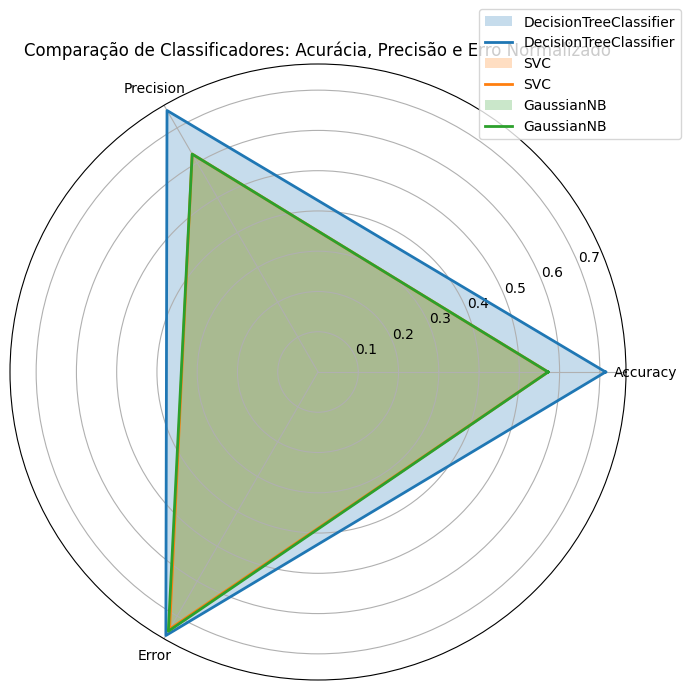

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_error(errors, max_value=12):
    return [e / max_value for e in errors]

metrics = ['Accuracy', 'Precision', 'Error']
classifiers = results_accuracy.keys()
normalized_error = normalize_error(list(results_error.values()), max_value=12)

data = {}
i = 0
for classifier in classifiers:
    acc = results_accuracy[classifier]
    prec = results_precision[classifier]
    err = normalized_error[i]
    i += 1
    data[classifier] = [acc, prec, 1 - err]  # Subtraindo o erro de 1 para manter a lógica (quanto maior, melhor)

# Ângulos para o Radar Chart
num_metrics = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Fechar o radar

# Plot do gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for classifier, values in data.items():
    values += values[:1]  # Fechar o gráfico
    ax.fill(angles, values, alpha=0.25, label=classifier)
    ax.plot(angles, values, linewidth=2, label=f"{classifier}")

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_title("Comparação de Classificadores: Acurácia, Precisão e Erro Normalizado")
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()


In [42]:
os.makedirs('data_prediction', exist_ok=True)

for k,v in BEST_MODELS.items():
    v.to_csv(os.path.join('data_prediction', k+'.csv'), index=False)